In [24]:
import numpy
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.utils import to_categorical
from sklearn.svm import SVC
from sklearn.svm import SVR
from numpy import array
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from numpy.lib.stride_tricks import as_strided as ast
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from matplotlib import pyplot
from numpy.lib.stride_tricks import as_strided as ast
import itertools
import operator
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from keras import regularizers
        
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
import pickle

import datetime

# CuDNNLSTM is not available in Keras v2, you would need to use the standard LSTM layer
# from keras.layers import CuDNNLSTM


In [47]:
import matplotlib
import matplotlib.pyplot as plt

def evaluateWeightedPerformance(cm):
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    summ = np.sum(cm, axis=1)
    TN = []
    precision =[]
    FMeaure = []
    recall = []
    accuracy = []
    for i in range(len(TP)):
        temp = np.delete(cm, i, 0)    # delete ith row
        temp = np.delete(temp, i, 1)  # delete ith column
        TN.append(sum(sum(temp)))
    message = "TP = " + str(TP)+"\n"
    print(message)
    message = "FP = " + str(FP)+"\n"
    print(message)
    message = "FN = " + str(FN)+"\n"
    print(message)
    message = "TN = " + str(TN)+"\n"
    print(message)
    for i in range(0, len(TP)):
        if(TP[i] == 0 and FP[i] == 0):
            precision.append(0)
            FMeaure.append(0)
            recall.append(TP[i]/(TP[i]+FN[i]))
            accuracy.append((TN[i]+TP[i])/(TN[i]+FP[i]+FN[i]+TP[i]))
        else:
            precision.append(TP[i]/(TP[i]+FP[i]))
            recall.append(TP[i]/(TP[i]+FN[i]))
            FMeaure.append(2*(precision[i]*recall[i])/(recall[i]+precision[i]))
            accuracy.append((TN[i]+TP[i])/(TN[i]+FP[i]+FN[i]+TP[i]))
##    message = "precision "+str(precision)+"\n"
##    print(message)
##    message = "recall "+str(recall)+"\n"
##    print(message)
##    message = "FMeaure "+str(FMeaure)+"\n"
##    print(message)
##    message = "accuracy "+str(accuracy)+"\n"
##    print(message)
    sumsum = 0
    weightedaccuracy = 0
    weightedFMeaure= 0
    weightedrecall = 0
    weightedprecision = 0
    for i in range(0, len(precision)):
        weightedprecision = weightedprecision+precision[i]*summ[i]
        weightedrecall = weightedrecall+recall[i]*summ[i]
        weightedFMeaure = weightedFMeaure+FMeaure[i]*summ[i]
        weightedaccuracy = weightedaccuracy+accuracy[i]*summ[i]
        sumsum = summ[i]+sumsum
    weightedprecision = weightedprecision/sumsum
    weightedrecall = weightedrecall/sumsum
    weightedFMeaure = weightedFMeaure/sumsum
    weightedaccuracy = weightedaccuracy/sumsum
    precision = np.average(precision)
    recall = np.average(recall)
    FMeaure = np.average(FMeaure)
    accuracy = np.average(accuracy)
##    message = "Average precision "+str(precision)+"\n"
##    print(message)
##    message = "Average recall "+str(recall)+"\n"
##    print(message)
##    message = "Average FMeaure "+str(FMeaure)+"\n"
##    print(message)
##    message = "Average accuracy "+str(accuracy)+"\n"
##    print(message)
    message = "Weighted precision "+str(weightedprecision)+"\n"
    print(message)
    message = "Weighted recall "+str(weightedrecall)+"\n"
    print(message)
    message = "Weighted FMeaure "+str(weightedFMeaure)+"\n"
    print(message)
    message = "Weighted accuracy "+str(weightedaccuracy)+"\n"
    print(message)
    
    
def norm_shape(shape):
    '''
    Normalize numpy array shapes so they're always expressed as a tuple,
    even for one-dimensional shapes.
    Parameters
        shape - an int, or a tuple of ints
    Returns
        a shape tuple
    '''
    try:
        i = int(shape)
        return (i,)
    except TypeError:
        # shape was not a number
        pass

    try:
        t = tuple(shape)
        return t
    except TypeError:
        # shape was not iterable
        pass

    raise TypeError('shape must be an int, or a tuple of ints')

def sliding_window(a,ws,ss = None,flatten = True):
    '''
    Return a sliding window over a in any number of dimensions
    Parameters:
        a  - an n-dimensional numpy array
        ws - an int (a is 1D) or tuple (a is 2D or greater) representing the size
             of each dimension of the window
        ss - an int (a is 1D) or tuple (a is 2D or greater) representing the
             amount to slide the window in each dimension. If not specified, it
             defaults to ws.
        flatten - if True, all slices are flattened, otherwise, there is an
                  extra dimension for each dimension of the input.
    Returns
        an array containing each n-dimensional window from a
    '''

    if None is ss:
        # ss was not provided. the windows will not overlap in any direction.
        ss = ws
    ws = norm_shape(ws)
    ss = norm_shape(ss)
    print(str(ws))
    print(str(ss))

    # convert ws, ss, and a.shape to numpy arrays so that we can do math in every
    # dimension at once.
    ws = np.array(ws)
    ss = np.array(ss)
    shape = np.array(a.shape)
    # ensure that ws, ss, and a.shape all have the same number of dimensions
    ls = [len(shape),len(ws),len(ss)]
    if 1 != len(set(ls)):
        raise ValueError(\
        'a.shape, ws and ss must all have the same length. They were %s' % str(ls))

    # ensure that ws is smaller than a in every dimension
    if np.any(ws > shape):
        raise ValueError(\
        'ws cannot be larger than a in any dimension.\a.shape was %s and ws was %s' % (str(a.shape),str(ws)))

    # how many slices will there be in each dimension?
    newshape = norm_shape(((shape - ws) // ss) + 1)
    # the shape of the strided array will be the number of slices in each dimension
    # plus the shape of the window (tuple addition)
    newshape += norm_shape(ws)
    # the strides tuple will be the array's strides multiplied by step size, plus
    # the array's strides (tuple addition)
    newstrides = norm_shape(np.array(a.strides) * ss) + a.strides
    strided = ast(a,shape = newshape,strides = newstrides)
    if not flatten:
        return strided

    # Collapse strided so that it has one more dimension than the window.  I.e.,
    # the new array is a flat list of slices.
    meat = len(ws) if ws.shape else 0
    firstdim = (np.product(newshape[:-meat]),) if ws.shape else ()
    dim = firstdim + (newshape[-meat:])
    return strided.reshape(dim)

def opp_sliding_window(data_x, data_y, ws, ss, flatten=True):
    data_x = sliding_window(data_x, (ws, data_x.shape[1]), (ss, 1), flatten)#(data_x, (ws, data_x.shape[1]), (ss, 1), flatten)
    #data_x = sliding_window(data_x,ws, ss, flatten)
    # This Command will assign the last sample class to be the window class
    # data_y = np.asarray([[i[-1]] for i in sliding_window(data_y,ws,ss)])
    # This Commands will assign the most dominant class to be the window class
    windows = sliding_window(data_y, ws, ss, flatten)
    mostDom = []
    for i in windows:
        mostDom.append(most_common(i))
    data_y = np.asarray(mostDom)
    return data_x.astype(np.float32), data_y.reshape(len(data_y)).astype(np.uint8)

def most_common(L):
    # get an iterable of (item, iterable) pairs
    SL = sorted((x, i) for i, x in enumerate(L))
    # print 'SL:', SL
    groups = itertools.groupby(SL, key=operator.itemgetter(0))

    # auxiliary function to get "quality" for an item
    def _auxfun(g):
        item, iterable = g
        count = 0
        min_index = len(L)
        for _, where in iterable:
            count += 1
            min_index = min(min_index, where)
        # print 'item %r, count %r, minind %r' % (item, count, min_index)
        return count, -min_index

    # pick the highest-count/earliest item
    return max(groups, key=_auxfun)[0]

# load the dataset, returns train and test X and y elements
def load_dataset(modelName):
        # load dataset
        #dataset = open("OnlyActivities.csv", "r")
        dataset = open("oa.csv", "r")
        
        lines = dataset.readlines()
        dataLength= len(lines)
        number = 0
        splitRateTrainTest = 0.7
        # splitRateTrainTest = 1.0
        trainSize = round(dataLength*splitRateTrainTest)
        testSize = dataLength - trainSize
        for x in lines:
            if(number == 0):
                partsV0 = x.split('\n', 1)
                featuresV0 = partsV0[0].split(',')
                NumberofFeatures= len(featuresV0)
                number = number +1
        data = [[0 for k in range (NumberofFeatures)] for l in range (dataLength)]
        re = 0
        for x in lines:
            parts = x.split('\n', 1)
            features = parts[0].split(',')
            data[re] = features
            re = re+1
        data = array(data)
        datafeature = data[:, 2:-1]
        datalabel = data[:, -1]
        WindowSize= 128
        Overlapp= 64
        if(modelName == "CNN-LSTM" or modelName == "CNN" or modelName == "LSTM"):
            data, label = opp_sliding_window(datafeature, datalabel, WindowSize, Overlapp)
        else:
            data = datafeature
            label = datalabel
        datasizeAfterWindowing= len(data)
        
        testSize = int(0.3*datasizeAfterWindowing)
        trainSize=datasizeAfterWindowing-testSize
        print(f'trainsize:{trainSize} testsize:{testSize}')
        trainX = data[0:trainSize, :]
        trainy = label[0:trainSize]
        testX = data[trainSize:, :]#[trainSize+1:(datasizeAfterWindowing),:]
        testy = label[trainSize:]#label[trainSize+1:(datasizeAfterWindowing)]
        trainy = to_categorical(trainy, num_classes=17)
        testy = to_categorical(testy, num_classes=17)
        return trainX, trainy, testX, testy

# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [54]:
modelName = "CNN-LSTM"

trainX, trainy, testX, testy = load_dataset(modelName)

scores = list()
precisions = list()
recalls = list()
f1s = list()

(128, 235)
(64, 1)
(128,)
(64,)
trainsize:3626 testsize:1553


In [ ]:
trainX.shape,testX.shape

In [55]:
verbose = 1 #0, 1000, 60

n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
print("n_timesteps = ")
print(n_timesteps)
print("n_features = ")
print(n_features)
print("n_outputs = ")
print(n_outputs)
# reshape data into time steps of sub-sequences
#n_steps, n_length = 4, 32
n_steps, n_length = 4, 32
# n_steps, n_length = 1, 32*4
trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Conv1D(filters=16, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.4)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(units=200, return_sequences=True))
model.add(LSTM(units=100, return_sequences=True))
model.add(LSTM(units=100))
model.add(Dropout(0.4))
#model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
#model.add(Dense(100, activation='relu'))
#model.add(Dense(100, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

filepath="./weightsCNNLSTMAct12012022.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor=0.5,
                  patience=50, min_lr=0.0001)

r = datetime.datetime.now()
print (datetime.datetime.now())

# fit network
history = model.fit(trainX, trainy, epochs=500, batch_size=10, verbose=verbose, validation_split=0.2, callbacks = [reduce_lr,checkpoint])

print (r)
print (datetime.datetime.now())

print ("Saving History Model")

model.summary()

n_timesteps = 
128
n_features = 
235
n_outputs = 
17
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeD  (None, None, 30, 64)      45184     
 istributed)                                                     
                                                                 
 time_distributed_25 (TimeD  (None, None, 28, 32)      6176      
 istributed)                                                     
                                                                 
 time_distributed_26 (TimeD  (None, None, 26, 16)      1552      
 istributed)                                                     
                                                                 
 time_distributed_27 (TimeD  (None, None, 26, 16)      0         
 istributed)                                                     
                                                                 
 

c:\Users\Ali\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


288/290 [============================>.] - ETA: 0s - loss: 1.3387 - accuracy: 0.6844
Epoch 2: val_accuracy did not improve from 0.72039
290/290 [==============================] - 7s 23ms/step - loss: 1.3370 - accuracy: 0.6848 - val_loss: 1.2202 - val_accuracy: 0.7204 - lr: 0.0010
Epoch 3/500
289/290 [============================>.] - ETA: 0s - loss: 1.3219 - accuracy: 0.6844
Epoch 3: val_accuracy did not improve from 0.72039
290/290 [==============================] - 6s 21ms/step - loss: 1.3205 - accuracy: 0.6848 - val_loss: 1.2253 - val_accuracy: 0.7204 - lr: 0.0010
Epoch 4/500
288/290 [============================>.] - ETA: 0s - loss: 1.3249 - accuracy: 0.6840
Epoch 4: val_accuracy did not improve from 0.72039
290/290 [==============================] - 6s 21ms/step - loss: 1.3226 - accuracy: 0.6848 - val_loss: 1.2038 - val_accuracy: 0.7204 - lr: 0.0010
Epoch 5/500
289/290 [============================>.] - ETA: 0s - loss: 1.3002 - accuracy: 0.6848
Epoch 5: val_accuracy did not improv

In [56]:
with open('./trainHistory12012022', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

print ("History Model Saved")

History Model Saved


In [57]:
testX.shape

(1553, 4, 32, 235)

In [58]:
predictions = model.predict(testX)
prediction = []
testyindex = []
outputconfusionMatrixfile = open("confusion.txt","w")
predictionindex = []
for i in range(0, len(predictions)):
        prediction.append(0)
        predictionindex.append(0)
        testyindex.append(0)

for i in range(0, len(predictions)):
        prediction[i]= np.round(predictions[i], 2)
        for j in range(0, len(predictions[0])):
                if(predictions[i][j] == max(predictions[i])):
                        predictionindex[i] = j
                if(testy[i][j] == max(testy[i])):
                        testyindex[i] = j
print("len(predictionindex)= ", str(len(predictionindex)))
print("len(testyindex) = ", str(len(testyindex)))
filewriter = open("CNN-LSTM-Orange4Home-Output.txt", "w")
for i in range(0, len(testyindex)):
    message = str(i)+ " "+ str(testyindex[i])+" "+ str(predictionindex[i])+"\n"
    filewriter.write(message)
filewriter.close()
np.set_printoptions(threshold=np.inf)
cm = confusion_matrix(testyindex, predictionindex, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
evaluateWeightedPerformance(cm)
with open("confusionOnlyActivities.txt", 'w') as f:
        f.write(np.array2string(cm, separator=', '))
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testyindex, predictionindex)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testyindex, predictionindex, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testyindex, predictionindex, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testyindex, predictionindex, average='weighted')
print('F1 score: %f' % f1)
outputconfusionMatrixfile.close()
    #return accuracy, precision, recall, f1

49/49 [==============================] - 2s 14ms/step
len(predictionindex)=  1553
len(testyindex) =  1553
TP = [  0   0   6   0   0  27   0 837   0   6   0   1   0   0   8   3   0]

FP = [  4   0  45  14   0 107  16 179   6  81  31  22   7   0  80  72   1]

FN = [ 10   0  44  21   0  89   9 259   9  32  37  22   4   3  45  55  26]

TN = [1539, 1553, 1458, 1518, 1553, 1330, 1528, 278, 1538, 1434, 1485, 1508, 1542, 1550, 1420, 1423, 1526]

Weighted precision 0.6071602514835239

Weighted recall nan

Weighted FMeaure nan

Weighted accuracy 0.7798179706601974

Accuracy: 0.571797
Precision: 0.607160
Recall: 0.571797
F1 score: 0.587881


C:\Users\Ali\AppData\Local\Temp\ipykernel_14456\4129582141.py:35: RuntimeWarning: invalid value encountered in double_scalars
  FMeaure.append(2*(precision[i]*recall[i])/(recall[i]+precision[i]))
C:\Users\Ali\AppData\Local\Temp\ipykernel_14456\4129582141.py:30: RuntimeWarning: invalid value encountered in longlong_scalars
  recall.append(TP[i]/(TP[i]+FN[i]))
c:\Users\Ali\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
from keras.models import load_model
import keras

def modelImport():
    tunedModel = load_model("./weightsCNNLSTMAct12012022.best.hdf5")
    optimizer = keras.optimizers.Adam()
    tunedModel.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return tunedModel

In [60]:
def prediction(tunedModel, dataPrepared):
    predictClass = tunedModel.predict(dataPrepared)
    predictProba = tunedModel.predict_proba(dataPrepared)
    classes = np.argmax(predictClass, axis=1)
    Proba = np.argmax(predictProba, axis=1)
    print (classes)
    print ("predictedProbability",predictProba)
    print ("Probability",Proba)
    return classes, Proba

In [61]:
tunedModel = modelImport()

In [62]:
n_steps, n_length = 4, 32
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
# trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
# testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
predictions = tunedModel.predict(testX)

49/49 [==============================] - 2s 14ms/step


In [63]:
def prediction(tunedModel, dataPrepared):
    predictClass = tunedModel.predict(dataPrepared)
    predictProba = tunedModel.predict_proba(dataPrepared)
    classes = np.argmax(predictClass, axis=1)
    Proba = np.argmax(predictProba, axis=1)
    print (classes)
    print ("predictedProbability",predictProba)
    print ("Probability",Proba)
    return classes, Proba

In [64]:
def labelsPrediction(classes):
    LABELS = [
            "Entering",
            "Going_up",
            "Showering",
            "Using_the_sink",
            "Going_down",
            "Watching_TV",
            "Using_the_toilet",
            "Computing",
            "Preparing",
            "Cooking",
            "Eating",
            "Washing_the_dishes",
            "Cleaning",
            "Dressing",
            "Reading",
            "Napping",
            "Leaving"]

    if classes == 0:
        x = LABELS[0]
        print ("The Activity is: ", x)
    elif classes == 1:
        x = LABELS[1]
        print ("The Activity is: ", x)
    elif classes == 2:
        x = LABELS[2]
        print ("The Activity is: ", x)
    elif classes == 3:
        x = LABELS[3]
        print ("The Activity is: ", x)
    elif classes == 4:
        x = LABELS[4]
        print ("The Activity is: ", x)
    elif classes == 5:
        x = LABELS[5]
        print ("The Activity is: ", x)
    elif classes == 6:
        x = LABELS[6]
        print ("The Activity is: ", x)
    elif classes == 7:
        x = LABELS[7]
        print ("The Activity is: ", x)
    elif classes == 8:
        x = LABELS[8]
        print ("The Activity is: ", x)
    elif classes == 9:
        x = LABELS[9]
        print ("The Activity is: ", x)
    elif classes == 10:
        x = LABELS[10]
        print ("The Activity is: ", x)
    elif classes == 11:
        x = LABELS[11]
        print ("The Activity is: ", x)
    elif classes == 12:
        x = LABELS[12]
        print ("The Activity is: ", x)
    elif classes == 13:
        x = LABELS[13]
        print ("The Activity is: ", x)
    elif classes == 14:
        x = LABELS[14]
        print ("The Activity is: ", x)
    elif classes == 15:
        x = LABELS[16]
        print ("The Activity is: ", x)
    
    return x

In [65]:
print (trainX.shape)
print (trainy.shape)
print (testX.shape)
print (testy.shape)

(3626, 4, 32, 235)
(3626, 17)
(1553, 4, 32, 235)
(1553, 17)


In [66]:
fff = 559 #48997 #49010 #53083 #54522 #55048 #55904 #57580 #57601 #57727 #59836 #60565 #62344 #21212
ss = testX[fff, testX.shape[1], testX.shape[2], testX.shape[3]]

print (testX[fff].shape)

IndexError: index 4 is out of bounds for axis 1 with size 4

In [67]:
ssss, proba = prediction(tunedModel, ss)

NameError: name 'ss' is not defined

In [ ]:
predicted  = labelsPrediction(ssss)

In [73]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

predict_y = tunedModel.predict(testX, batch_size=10, verbose=1)

156/156 [==============================] - 1s 7ms/step


In [72]:
classes = np.argmax(predict_y, axis=0)
testy = np.argmax(testy, axis=0)
print (classes.shape)
print (testy)

(17,)
16


In [71]:
print(confusion_matrix(testy, classes))
print(classification_report(testy, classes, target_names=LABELS))

ValueError: Found input variables with inconsistent numbers of samples: [17, 1553]

In [76]:
# import training history
import pickle

history = pickle.load(open('./trainHistory12012022', "rb"))

s = history

print (type(history))
print (len(history['accuracy']))
print (history['accuracy'][0])

<class 'dict'>
500
0.6789655089378357


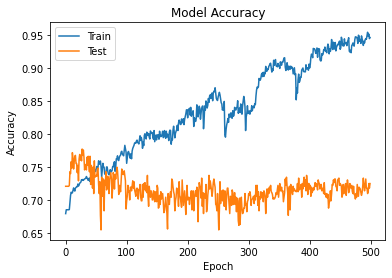

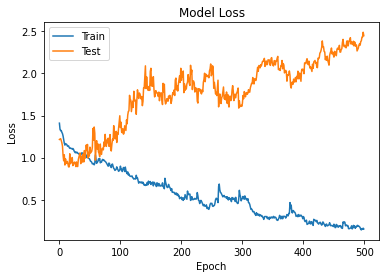

In [77]:
# ACC = 0.98269
import matplotlib.pyplot as plt
%matplotlib inline  


# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()